In [34]:
%load_ext autoreload
%autoreload 2
import sys
import logging
from pathlib import Path
import configparser

from lmfit import fit_report
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt

from gaussian_model import SingleGaussian, DoubleGaussian
from image import Image
from res import config

#### Config ####
constants = configparser.ConfigParser()
constants.read('res/constants.ini')

data_folder = 'res/images'
min_distance = 50 # minimum distance between stars to perform Gaussian
date = '7-7-2022'
indices = [f'_{x}' for x in 'ABCDEFGHI']

#### Logging ####
log = logging.getLogger('psfphot')
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger('parso.python.diff').disabled = True # turn off IPython debugging
logging.getLogger('matplotlib').setLevel(logging.WARNING)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analyze star nearby Pluto and Charon to estimate $\sigma_x$, $\sigma_y$, and $\theta$

In [35]:
dim = 60 # n by n dimension of subimage
for index in indices:
    log.info(f'{date}{index}')
    path = f'{data_folder}/{date}/pluto{index}.fits'
    entry = constants[f'{date}{index}']
    image = Image(path).subimage(entry['ref_star_x'], entry['ref_star_y'], dim, dim)
    image.write_fits(f'res/images/{date}/refstar{index}.fits')
    psfinit = {}
    psfinit['a'] = 500
    psfinit['bg'] = 500
    psfinit['xc'] =  dim/2
    psfinit['yc'] = dim/2
    psfinit['theta'] = 0
    psfinit['sigma_x'] = 5
    psfinit['sigma_y'] = 5

    psf = SingleGaussian(psfinit, image)
    psf.set_vary(['a', 'bg', 'xc', 'yc', 'theta', 'sigma_x', 'sigma_y'])
    psf.set_limits('a', 100, 5000)
    psf.set_limits('bg', 100, 1500)
    psf.set_limits('xc', 0, dim)
    psf.set_limits('yc', 0, dim)
    psf.set_limits('sigma_x', 0, 50)
    psf.set_limits('sigma_y', 0, 50)
    params = psf.run_minimizer()
    log.info(psf.get_result())
    log.info(fit_report(params, show_correl=False))

    entry['sigma_x'] = str(params['sigma_x'].value)
    entry['sigma_y'] = str(params['sigma_y'].value)
    entry['theta'] = str(params['theta'].value*180/np.pi % 360)
    constants.write(Path('res/constants.ini').open('w'))
    


INFO:psfphot:7-7-2022_A
DEBUG:image:Created Image res/images/7-7-2022/pluto_A.fits: 5069 x 4178
DEBUG:image:Created Image: 60 x 60
DEBUG:image:Destroyed Image res/images/7-7-2022/pluto_A.fits: 5069 x 4178
DEBUG:image:Destroyed Image res/images/6-9-2022/pluto_charon_K.fits: 60 x 60
INFO:psfphot:`ftol` termination condition is satisfied.
INFO:psfphot:[[Variables]]
    a:        3561.60740 +/- 4.98675496 (0.14%) (init = 500)
    bg:       513.306979 +/- 0.48952242 (0.10%) (init = 500)
    xc:       31.3768432 +/- 0.00563622 (0.02%) (init = 30)
    yc:       35.9977981 +/- 0.00665612 (0.02%) (init = 30)
    theta:    0.04354716 +/- 0.00590213 (13.55%) (init = 0)
    sigma_x:  4.02395183 +/- 0.00574166 (0.14%) (init = 5)
    sigma_y:  4.75516801 +/- 0.00678501 (0.14%) (init = 5)
INFO:psfphot:7-7-2022_B
DEBUG:image:Created Image res/images/7-7-2022/pluto_B.fits: 5069 x 4178
DEBUG:image:Created Image: 60 x 60
DEBUG:image:Destroyed Image res/images/7-7-2022/pluto_B.fits: 5069 x 4178
DEBUG:imag

## Use above values to fit Pluto and Charon psf

In [36]:
dim = 60
for index in indices:
    log.info(f'{date}{index}')
    path = f'{data_folder}/{date}/pluto{index}.fits'
    entry = constants[f'{date}{index}']
    image = Image(path).subimage(entry['pluto_charon_x'], entry['pluto_charon_y'], dim, dim)
    image.write_fits(f'res/images/{date}/pluto_charon{index}.fits')
    psfinit = {}
    psfinit['a_p'] = 250
    psfinit['rel_flux'] = float(constants[f'{date}'][f'rel_flux'])
    psfinit['bg'] = 500
    psfinit['x_p'] =  dim/2
    psfinit['y_p'] = dim/2
    psfinit['dx'] = float(constants[f'{date}'][f'dx_guess'])
    psfinit['dy'] = float(constants[f'{date}'][f'dy_guess'])
    psfinit['theta'] = float(entry['theta']) * np.pi/180
    psfinit['sigma_x'] = float(entry['sigma_x'])
    psfinit['sigma_y'] = float(entry['sigma_y'])

    psf = DoubleGaussian(psfinit, image)
    psf.set_vary(['a_p', 'bg', 'x_p', 'y_p', 'dx', 'dy'])
    psf.set_limits('a_p', 100, 5000)
    psf.set_limits('bg', 100, 1500)
    psf.set_limits('x_p', 0, dim)
    psf.set_limits('y_p', 0, dim)
    psf.set_limits('dx', -8.5, 8.5)
    psf.set_limits('dy', -8.5, 8.5)
    params = psf.run_minimizer()
    log.info(psf.get_result())
    log.info(fit_report(params, show_correl=False))

    entry['dx'] = str(params['dx'].value)
    entry['dy'] = str(params['dy'].value)
    constants.write(Path('res/constants.ini').open('w'))
    


INFO:psfphot:7-7-2022_A
DEBUG:image:Created Image res/images/7-7-2022/pluto_A.fits: 5069 x 4178
DEBUG:image:Created Image: 60 x 60
DEBUG:image:Destroyed Image res/images/7-7-2022/pluto_A.fits: 5069 x 4178
DEBUG:image:Destroyed Image res/images/7-7-2022/refstar_I.fits: 60 x 60
INFO:psfphot:`ftol` termination condition is satisfied.
INFO:psfphot:[[Variables]]
    a_p:       342.126595 +/- 0.65852791 (0.19%) (init = 250)
    rel_flux:  0.1760354 (fixed)
    bg:        500.606701 +/- 0.07970537 (0.02%) (init = 500)
    x_p:       28.1563745 +/- 0.01062103 (0.04%) (init = 30)
    y_p:       30.2553206 +/- 0.01597703 (0.05%) (init = 30)
    dx:       -4.53686759 +/- 0.07452817 (1.64%) (init = -1.5)
    dy:       -1.50214965 +/- 0.10317103 (6.87%) (init = -1.5)
    theta:     0.04354716 (fixed)
    sigma_x:   4.023952 (fixed)
    sigma_y:   4.755168 (fixed)
INFO:psfphot:7-7-2022_B
DEBUG:image:Created Image res/images/7-7-2022/pluto_B.fits: 5069 x 4178
DEBUG:image:Created Image: 60 x 60
DEBUG:

## Plot pluto and charon results

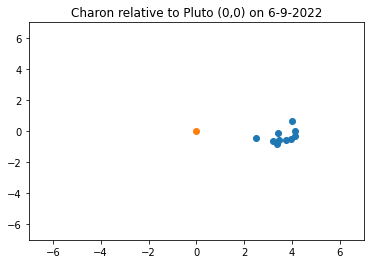

In [33]:
dx = [float(constants[f'{date}{index}']['dx']) for index in indices]
dy = [float(constants[f'{date}{index}']['dy']) for index in indices]
%matplotlib inline
plt.figure()
plt.title(f'Charon relative to Pluto (0,0) on {date}')
plt.xlim((-7,7))
plt.ylim((-7,7))
plt.scatter(dx, dy)
plt.scatter([0], [0])
plt.show()

['res/constants.ini']